# CNN(PyTorch) - Transfer Learning (VGG) to classify images
* Project: To classify flower dataset images using VGG
* Project Scope: Apply [VGGNET](https://arxiv.org/pdf/1409.1556.pdf) and train on the [Flower dataset](http://www.image-net.org/) as a feature extractor
* Data: [Data](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip)

Below is a diagram of the VGGNet architecture, with a series of convolutional and maxpooling layers, then three fully-connected layers at the end that classify the 1000 classes found in the ImageNet database.
<img src="vgg_16_architecture.png" width=700px>

Flower dataset falls in the category of small (size dataset) and have similar (images to VGG training) data. So approch will be to use VGG model just by replacing VGG's full connected layer with new layer with classes that match to our dataset. Also we will be freezing all the pre-trained weights (to avoid over fitting) and update with weights of new fully connected layer

### Importing Libraries and Packages

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim

### Checking for CUDA

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


### Loading data

In [3]:
# define data directory
data_dir = 'flower_photos/'
# Number of subprocesses to use for data loading
num_workers = 0
# Sample batch size to load
batch_size = 20
# Percentage of training set to use as validation
valid_size = 0.2

# VGG-16 Takes 224x224 images as input, so we resize all of them
transform = transforms.Compose([transforms.RandomResizedCrop(224), transforms.ToTensor()])
# Getting train and test datasets
train_data = datasets.ImageFolder(root = data_dir+'/train', transform=transform)
test_data = datasets.ImageFolder(root = data_dir+'/test', transform=transform)

# Creating indices to split train data
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Creating training and validation sampler
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# print out some data stats
print('Num training images: ', len(train_sampler))
print('Num validation images: ', len(valid_sampler))
print('Num test images: ', len(test_data))

# Creating train, validation and test loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

Num training images:  2504
Num validation images:  626
Num test images:  540


### Visualize a Batch of Training Data

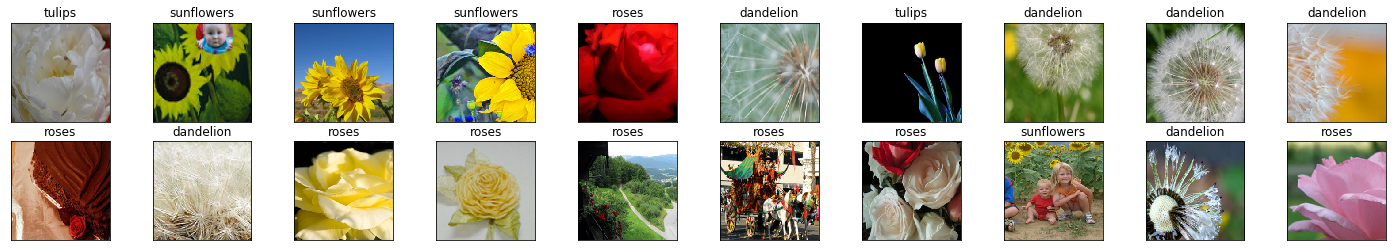

In [4]:
# Obtain a batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

### Defining the model, Loss Function and Optimizer

In [5]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

We can see the vgg16.classifier[6] got 4096 in_features and 1000 out_features

#### Freeze training for all "features" layers

In [6]:
for param in vgg16.features.parameters():
    param.requires_grad = False

#### Defining classifier's final fully connected  layer for our model

This layer will input the number of features produced by the portion of the network that you are not changing, and produce an appropriate number of outputs for the flower classification task

In [7]:
n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)

5


#### Loss Function and Optimizer

In [8]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

### Training

In [9]:
epochs = 2

for e in range(epochs):
    # moditoring train and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    train_time = time.time()
    ###################
    # train the model #
    ###################
    for i, (image, label) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            image, label = image.cuda(), label.cuda()
        optimizer.zero_grad()                  # Clearing previous gradients
        output = vgg16(image)                  # Forward pass: compute predicted outputs
        loss = criterion(output,label)         # Calculating the loss
        loss.backward()                        # Backward pass: Compute gradient of the loss
        optimizer.step()                       # Perform single optimizer step
        train_loss += loss.item()              # updating running training loss
        if i % 20 == 19:
            print("Epoch: {}".format(e+1),
                  "Batch: {}".format(i+1),
                  "Train Loss: {:.4f}".format(train_loss / 20),
                  "Estimated time : {:.2f} seconds".format(time.time() - train_time))
            train_loss = 0.0
            train_time = time.time()
        
    ######################
    # Validate the model #
    ######################
    vgg16.eval()                              # Enabling the network evaluation mode
    valid_time = time.time()
    for i, (image, label) in enumerate(valid_loader):
        if train_on_gpu:
            image, label = image.cuda(), label.cuda()
        output = vgg16(image)                  # Forward pass: compute predicted outputs
        loss = criterion(output,label)         # Calculating the loss
        valid_loss += loss.item()              # updating running validation loss
        
        # print training/valiadtion loss every specified number of mini-batches        
        if i % 20 == 19:    
            print("Epoch: {}".format(e+1),
                  "Batch: {}".format(i+1),
                  "Valid Loss: {:.4f}".format(valid_loss / 20),
                  "Estimated time : {:.2f} seconds".format(time.time() - valid_time))
            valid_loss = 0.0
            valid_time = time.time()

Epoch: 1 Batch: 20 Train Loss: 1.5257 Estimated time : 305.98 seconds
Epoch: 1 Batch: 40 Train Loss: 1.3490 Estimated time : 300.65 seconds
Epoch: 1 Batch: 60 Train Loss: 1.1896 Estimated time : 304.14 seconds
Epoch: 1 Batch: 80 Train Loss: 1.1153 Estimated time : 311.50 seconds
Epoch: 1 Batch: 100 Train Loss: 1.0614 Estimated time : 305.86 seconds
Epoch: 1 Batch: 120 Train Loss: 0.9987 Estimated time : 285.91 seconds
Epoch: 1 Batch: 20 Valid Loss: 0.9470 Estimated time : 282.96 seconds
Epoch: 2 Batch: 20 Train Loss: 0.8592 Estimated time : 308.22 seconds
Epoch: 2 Batch: 40 Train Loss: 0.8652 Estimated time : 307.98 seconds
Epoch: 2 Batch: 60 Train Loss: 0.8414 Estimated time : 304.07 seconds
Epoch: 2 Batch: 80 Train Loss: 0.8058 Estimated time : 307.76 seconds
Epoch: 2 Batch: 100 Train Loss: 0.7243 Estimated time : 305.88 seconds
Epoch: 2 Batch: 120 Train Loss: 0.7971 Estimated time : 296.75 seconds
Epoch: 2 Batch: 20 Valid Loss: 0.7310 Estimated time : 263.38 seconds


### Testing

In [44]:
#####################
# Testing the model #
#####################
# Initializing the test loss
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval()                               # Enabling the network evaluation mode

for image, label in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        image, label = image.cuda(), label.cuda()
    
    output = vgg16(image)                  # Forward pass: compute predicted outputs
    loss = criterion(output,label)         # Calculating the loss
    test_loss += loss.item()*image.size(0) # updating running validation loss
    _, pred = torch.max(output, 1)    # Converting output probabilities to predicted class
    correct_tensor = pred.eq(label.data.view_as(pred)) # compare predictions to true label
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    # calculate test accuracy for each object class
    for i in range(batch_size):
        class_correct[label.data[i]] += correct[i].item()
        class_total[label.data[i]] += 1

# Printing test accuracy for each object class
for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %2s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %2s: N/A (no training examples)' % (classes[i]))

# Printing test loss and accuracy
print("Test Loss: {:.4f} ".format(test_loss/len(test_loader.dataset)),
      "Test Accuracy (overall): {:.2f}% ".format(100. * np.sum(class_correct) / np.sum(class_total)))

Test Accuracy of daisy: 75% (69/92)
Test Accuracy of dandelion: 90% (119/132)
Test Accuracy of roses: 67% (61/91)
Test Accuracy of sunflowers: 75% (76/101)
Test Accuracy of tulips: 70% (88/124)
Test Loss: 0.7353  Test Accuracy (overall): 76.48% 


### Visualize test results

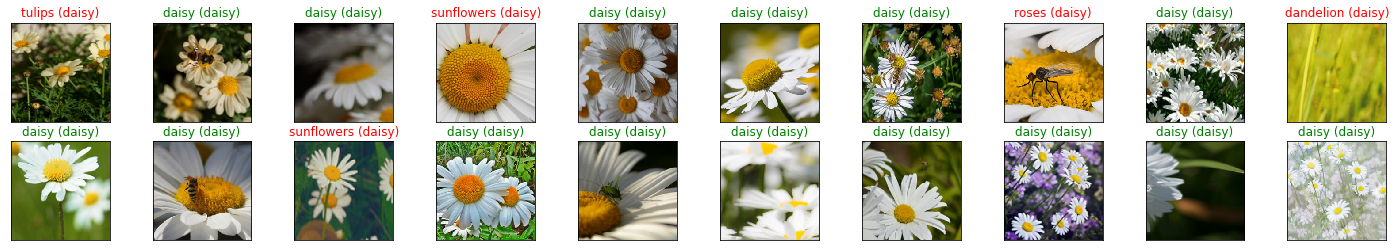

In [45]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))